In [1]:
import numpy as n
import pylab as pl
import time,os,h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import interpolate

/Users/wiltbemj/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
%matplotlib inline

In [3]:
os.chdir('/Users/wiltbemj/Dropbox/Python/MHDpy/')
import MHDpy

In [4]:
# Model Parameters
NO = 8                # - default 8th order, hard coded for PDM
NO2 = NO/2            # num of ghost cells on each end
gamma=5.0/3.0         # ratio of the specific heat, 5/3 for ideal gas
CFL = 0.3             # Courant number
PDMB= 4.0             # PDM beta parameter for controlling numerical diffusion
CA = 10               # speed of light, normalized with VA, 
                      #    use something like 1e10 no Boris correction
limiter_type = 'PDM'  # 'PDM' - 8th order with PDM limiter
                      # 'TVD' - 2nd order with Van-Leer limiter
                      # '8th' - 8th order without limiter
                      # 'WENO'- 5th order with WENO reconstruction 
                      #         (not tested in the getEk algorithm yet)
                      # 'PPM' - 3rd order PPM method (not tested yet)
nsp = 2               # number of species
Hall = False          # Hall Term on
SaveData = False      # Save the output data

imagedir = '/Users/wiltbemj/Downloads/figs' # directory to store image files
imagebase = 'gem' # base name of image files
imageint = 50 #frequency of images
outdir = '/Users/wiltbemj/Downloads/MHDpy' # directory to store HDF5 files
outbase = 'gem' # base name of HDF5 files.
outint = 50 #Frequency to dump HDF5 files



In [5]:
# Grid information- nx,ny,nz are # of ACTIVE cells (no ghost cell included)
# The generated grid are cell corners, the metric function will calculate
# cell centers, faces and other grid information
nx = 64
ny = 32
nz = 1
(x,y,z)=MHDpy.Generate_Grid_3D_uniform(nx,ny,nz,NO) # This function generate a 
                                               # uniformly distributed active 
                                               # grid between -1 and 1 with 
                                               # nx, ny nz active cells in each 
                                               # direction
(nx_total,ny_total,nz_total)=x.shape           # with NO/2 ghost cells, 
                                               # nx_total, ny_total, nz_total 
                                               # are total num of cell corners

In [6]:
#BW
#x = (x+0.0)/1.0 # leave the grid on [-1 1]
#y = (y+0.0)/1.0 # y doesn't matter...
#z = (z+0.0)/1.0 # z doesn't matter...

In [7]:
#OT
#x = (x+1.0)/2.0 # map the grid from [-1 1] to [-0.5 -.5]
#y = (y+1.0)/2.0 # map the grid from [-1 1] to [-0.5 -.5]
#z = (z+0.0)/1.0 # z doesn't matter...

In [8]:
#GEM
x = (x+1.)/1.  #map the x grid from [-1 1] to [0 2]
y = (y+0.)/1.
z = (z+0.)/1.
Lx=25.6
Ly=12.8
x = Lx/2*x
y = Ly/2*y

In [9]:
# Calculate grids and indices
# xc,yc,zc: cell centers
# xi,yi,zi: i-face cetners where bi is defined
# xj,yj,zj: j-face cetners where bj is defined
# xk,yk,zk: k-face cetners where bk is defined
# dx,dy,dz: lengths of each cell edge
(xc,yc,zc,xi,yi,zi,xj,yj,zj,xk,yk,zk,dx,dy,dz)=MHDpy.Metrics(x,y,z,NO)




In [10]:
# Define premitive Hydrodynamic variables at cell center
rho = n.zeros(xc.shape)
vx = n.zeros(xc.shape)
vy = n.zeros(xc.shape)
vz = n.zeros(xc.shape)
p = n.zeros(xc.shape)

# Define species Hydrodynamic variables at cell center
rhos = n.zeros((nx_total-1,ny_total-1,nz_total-1,nsp))
vxs = n.zeros((nx_total-1,ny_total-1,nz_total-1,nsp))
vys = n.zeros((nx_total-1,ny_total-1,nz_total-1,nsp))
vzs = n.zeros((nx_total-1,ny_total-1,nz_total-1,nsp))
ps = n.zeros((nx_total-1,ny_total-1,nz_total-1,nsp))

#define some variables used in the calculation

rhos2 = rhos*0.
vxs2 = vxs*0.
vys2 = vys*0.
vzs2 = vzs*.0
engs2 = ps*.0
species_ratio = rhos*0
drho_l = rhos*0
alfn_star = rhos*0
perp_const_l = rhos*0
vxtmp = rhos*0
vytmp = rhos*0
vztmp = rhos*0
vx2_tmp = rhos*0
vy2_tmp = rhos*0
vz2_tmp = rhos*0
vx_para_l = rhos*0
vy_para_l = rhos*0
vz_para_l = rhos*0
vtmp_dotl = rhos*0
vtmp_dot_l2 = rhos*0

# Define Magnetic fields at cell faces
bi = n.zeros(xi.shape)
bj = n.zeros(xj.shape)
bk = n.zeros(xk.shape)

# Define Electric fields at cell edges
Ei = n.zeros((nx_total-1,ny_total,nz_total))
Ej = n.zeros((nx_total,ny_total-1,nz_total))
Ek = n.zeros((nx_total,ny_total,nz_total-1))

Time = 0.0

In [11]:
## 1-D Brio-Wu shock tube problem
#rho[xc<0.0] = 1.0
#rho[xc>0.0] = 0.125
#p[xc<0.0]   = 1.0
#p[xc>0.0]   = 0.1
#bi[:]  =  0.75
#bj[xj<0.0]  = 1.0
#bj[xj>0.0] = -1.0

In [12]:
#xbctype = 'EXP'
#ybctype = 'EXP'
#zbctype = 'EXP'

In [13]:
# 2-D Orzag-Tang vortex
#rho = rho+25.0/(n.pi*36.0)
#p   = p+5.0/(n.pi*12.0)
#vx  = -n.sin(2.0*n.pi*yc)
#vy  =  n.sin(2.0*n.pi*xc)
#bi  = -1.0/n.sqrt(4.0*n.pi)*n.sin(2*n.pi*yi)
#bj  = 1.0/n.sqrt(4.0*n.pi)*n.sin(2*n.pi*2*xj)

In [14]:
#xbctype = 'PER'
#ybctype = 'PER'
#zbctype = 'EXP'

In [15]:
# 2D OGEM Reconnection Challenge
mu0 = 4*n.pi*1e-7
epsilon0=8.85418782*1e-12
c=3e8
ech=1.60217657*1e-19
Mp = 1.67e-27 #[kg]
n0=1e16 #Density of particles per m^-3
t0 =Mp/(ech)
x0 = c*n.sqrt(epsilon0*Mp/(ech**2*n0)) #[m] 
u0 = x0/t0    #[m/s] - 100 km/
rho0=Mp*n0 # [kg/m^3] 
p0 = rho0*u0**2 #[N/m^2]
B0 = n.sqrt(mu0*rho0*u0**2) # [T]

no=1
lam=0.5
n_inf=0.2*no
Psi0=0.1


#Do Vector Potential Integration for Bi, Bj, Bk
LAi = n.zeros(x.shape)
LAj = n.zeros(x.shape)
LAk = n.zeros(x.shape)
for i in range(NO2,nx+NO2):
    xijk = x[i,NO2:-NO2+1,NO2:-NO2+1]
    xip1 = x[i+1,NO2:-NO2+1,NO2:-NO2+1]
    yijk = y[i,NO2:-NO2+1,NO2:-NO2+1]
    yip1 = y[i+1,NO2:-NO2+1,NO2:-NO2+1]
    zijk = z[i,NO2:-NO2+1,NO2:-NO2+1]
    zip1 = z[i+1,NO2:-NO2+1,NO2:-NO2+1]
    LAi[i,NO2:-NO2+1,NO2:-NO2+1]=((x[i+1,NO2:-NO2+1,NO2:-NO2+1]-
                               x[i,NO2:-NO2+1,NO2:-NO2+1])*
                              MHDpy.gaussLineInt(
                              MHDpy.Ax,xip1,yip1,zip1,xijk,yijk,zijk))
for j in range(NO2,ny+NO2):
    xijk = x[NO2:-NO2,j,NO2:-NO2]
    xjp1 = x[NO2:-NO2,j+1,NO2:-NO2]
    yijk = y[NO2:-NO2,j,NO2:-NO2]
    yjp1 = y[NO2:-NO2,j+1,NO2:-NO2]
    zijk = z[NO2:-NO2,j,NO2:-NO2]
    zjp1 = z[NO2:-NO2,j+1,NO2:-NO2]
    LAj[NO2:-NO2,j,NO2:-NO2]=((y[NO2:-NO2,j+1,NO2:-NO2]-
                               y[NO2:-NO2,j,NO2:-NO2])*
                              MHDpy.gaussLineInt(
                              MHDpy.Ay,xjp1,yjp1,zjp1,xijk,yijk,zijk))    
for k in range(NO2,nz+NO2):
    xijk = x[NO2:-NO2,NO2:-NO2,k]
    xkp1 = x[NO2:-NO2,NO2:-NO2,k+1]
    yijk = y[NO2:-NO2,NO2:-NO2,k]
    ykp1 = y[NO2:-NO2,NO2:-NO2,k+1]
    zijk = z[NO2:-NO2,NO2:-NO2,k]
    zkp1 = z[NO2:-NO2,NO2:-NO2,k+1]
    LAk[NO2:-NO2,NO2:-NO2,k]=((z[NO2:-NO2,NO2:-NO2,k+1]-
                               z[NO2:-NO2,NO2:-NO2,k])*
                              MHDpy.gaussLineInt(
                              MHDpy.Az,xkp1,ykp1,zkp1,xijk,yijk,zijk))

# Stokes theorm for bi, bj, bk - face-integrated flux diveded by area
bi[NO2:-NO2+1,NO2:-NO2,NO2:-NO2] = (LAj[NO2:-NO2+1,NO2:-NO2-1,NO2:-NO2-1] - 
                                    LAj[NO2:-NO2+1,NO2:-NO2-1,NO2+1:-NO2] +
                                    LAk[NO2:-NO2+1,NO2+1:-NO2,NO2:-NO2-1] -
                                    LAk[NO2:-NO2+1,NO2:-NO2-1,NO2:-NO2-1])
bj[NO2:-NO2:,NO2:-NO2+1,NO2:-NO2] = -(LAi[NO2:-NO2-1,NO2:-NO2+1,NO2:-NO2-1] -
                                      LAi[NO2:-NO2-1,NO2:-NO2+1,NO2+1:-NO2] +
                                      LAk[NO2+1:-NO2,NO2:-NO2+1,NO2:-NO2-1] -
                                      LAk[NO2:-NO2-1,NO2:-NO2+1,NO2:-NO2-1])
bk[NO2:-NO2:,NO2:-NO2,NO2:-NO2+1] = (LAi[NO2:-NO2-1,NO2:-NO2-1,NO2:-NO2+1] - 
                                     LAi[NO2:-NO2-1,NO2+1:-NO2,NO2:-NO2+1] +
                                     LAj[NO2+1:-NO2,NO2:-NO2-1,NO2:-NO2+1] -
                                     LAj[NO2:-NO2-1,NO2:-NO2-1,NO2:-NO2+1])
bi[NO2:-NO2+1,NO2:-NO2,NO2:-NO2] = (bi[NO2:-NO2+1,NO2:-NO2,NO2:-NO2]/
                                    dy[NO2:-NO2+2,NO2:-NO2,NO2:-NO2]/
                                    dz[NO2:-NO2+2,NO2:-NO2,NO2:-NO2])
bj[NO2:-NO2:,NO2:-NO2+1,NO2:-NO2] = (bj[NO2:-NO2:,NO2:-NO2+1,NO2:-NO2]/
                                     dz[NO2:-NO2,NO2:-NO2+2,NO2:-NO2]/
                                     dx[NO2:-NO2,NO2:-NO2+2,NO2:-NO2])
bk[NO2:-NO2:,NO2:-NO2,NO2:-NO2+1] = (bk[NO2:-NO2:,NO2:-NO2,NO2:-NO2+1]/
                                     dx[NO2:-NO2,NO2:-NO2,NO2:-NO2+2]/
                                     dy[NO2:-NO2,NO2:-NO2,NO2:-NO2+2])



In [16]:
#specfiy density and pressure
rho[NO2:-NO2,NO2:-NO2,NO2:-NO2]=(no*
    (n_inf/no+(1/(n.cosh(yc[NO2:-NO2,NO2:-NO2,NO2:-NO2]/lam)))**2))
p[NO2:-NO2,NO2:-NO2,NO2:-NO2]=0.5*(
                            1.0/(n.cosh(yc[NO2:-NO2,NO2:-NO2,NO2:-NO2]/lam)))**2+0.2

#adjust bi
bi[NO2:-NO2+1,NO2:-NO2,NO2:-NO2] = (bi[NO2:-NO2+1,NO2:-NO2,NO2:-NO2]+
                                  n.tanh(yi[NO2:-NO2+1,NO2:-NO2,NO2:-NO2]/lam))

In [17]:
# set boundary conditions 
# For GEM Reconnection x is peroidic and y is inflow/outflow
xbctype = 'PER'
ybctype = 'OUT'
zbctype = 'EXP'

In [18]:
MHDpy.Boundaries(rho,p,vx,vy,vz,bi,bj,bk,NO,
                xtype=xbctype,ytype=ybctype,ztype=zbctype)

In [19]:
bx = (bi[1:,:,:] + bi[:-1,:,:])/2.
by = (bj[:,1:,:] + bj[:,:-1,:])/2.
bz = (bk[:,:,1:] + bk[:,:,:-1])/2.

In [20]:
# Get conserved hydrodynamic variables
(rho,rhovx,rhovy,rhovz,eng) = MHDpy.getConservedVariables(rho,vx,vy,vz,p,gamma)

In [21]:
if (nsp > 1):
    mass = n.array([1,16]) # ion mass, H+ and O+
    rho_weight = n.array([0.8,0.2]) # 20% O+
    Ti = n.array([0.2,0.8]) # Partition pressure evenly between two species
    for i in n.arange(nsp):
        rhos[:,:,:,i] = rho_weight[i]*rho*mass[i]
        ps[:,:,:,i] = Ti[i]*p
        vxs[:,:,:,i] = vx
        vys[:,:,:,i] = vy
        vzs[:,:,:,i] = vz
        MHDpy.Boundaries(rhos[:,:,:,i],ps[:,:,:,i],vxs[:,:,:,i],vys[:,:,:,i],vzs[:,:,:,i],bi,bj,bk,NO,
                xtype=xbctype,ytype=ybctype,ztype=zbctype)
    rho = n.sum(rhos,axis=3)
    p = n.sum(ps,axis=3) 

In [22]:
# Get conserved hydrodynamic variables - species
(rhos,rhovxs,rhovys,rhovzs,engs) = MHDpy.getConservedVariables(rhos,vxs,vys,vzs,
                                                                ps,gamma)

In [23]:
dt0 = MHDpy.getDT(rho,vx,vy,vz,bx,by,bz,p,gamma,dx,dy,dz,CFL)

In [24]:
dt0

0.041485995699857808

In [25]:
# Save the initial states for the first Adam-Bashforth time stepping
rho_p = rho*1.
vx_p = vx*1.
vy_p = vy*1.
vz_p = vz*1.
p_p= p*1.
bx_p = bx*1.
by_p = by*1.
bz_p = bz*1.

bi_p = bi*1.
bj_p = bj*1.
bk_p = bk*1.

rhos_p = rhos*1.
vxs_p = vxs*1.
vys_p = vys*1.
vzs_p = vzs*1.
ps_p= ps*1.

In [26]:
# MAIN LOOP
# simulation Time information
count = 0
Nstep=10000
Time = 0
RealT=0
step=0
imageNum=0
flux = []
simTime = []

In [27]:
# calculate wave speeds for dt
Btotal = n.sqrt(bx**2+by**2+bz**2)
Valfvn = Btotal/n.sqrt(rho)
Va_eff = Valfvn*CA/n.sqrt(Valfvn**2+CA**2) # Boris-corrected VA

# Whistler speed, k*V_A^2, here I use k = 2*pi/(2*dy)
if(Hall):
    Vwist1 = 2.0*n.pi/(2*dy.min())*Va_eff**2
else:
    Vwist1 = n.zeros_like(Va_eff)

# wave speed for multi species: V_A+C_alpha+V_alpha+V_whistler
if(nsp > 1):
    Vsounds = n.sqrt(gamma*ps/rhos)
    Vfluids = n.sqrt(vxs**2+vys**2+vzs**2)
    temp = n.max((Vsounds+Vfluids),axis=3)
    VCFL = temp+Va_eff+Vwist1
else:
    Vfluid = n.sqrt(vx**2+vy**2+vz**2)
    Vsound = n.sqrt(gamma*p/rho)
    VCFL = Vfluid+Va_eff+Vsound+Vwist1

dtCFL = CFL /(VCFL/dx+VCFL/dy+VCFL/dz)
dt = dtCFL.min()

Time = Time + dt

In [29]:
    # get conserved variables-bulk
    (rho,rhovx,rhovy,rhovz,eng) = MHDpy.getConservedVariables(rho,vx,vy,vz,
                                                                p,gamma)
    # Get conserved hydrodynamic variables - species
    (rhos,rhovxs,rhovys,rhovzs,engs) = MHDpy.getConservedVariables(rhos,vxs,vys,
                                                                vzs,ps,gamma)

In [30]:
    # Step 1: get the half time step values - bulk
    rho_h = rho + dt/dt0/2*(rho-rho_p)
    vx_h = vx + dt/dt0/2*(vx-vx_p)
    vy_h = vy + dt/dt0/2*(vy-vy_p)
    vz_h = vz + dt/dt0/2*(vz-vz_p)
    p_h = p + dt/dt0/2*(p-p_p)
    bx_h = bx + dt/dt0/2*(bx-bx_p)
    by_h = by + dt/dt0/2*(by-by_p)
    bz_h = bz + dt/dt0/2*(bz-bz_p)
    bi_h = bi + dt/dt0/2*(bi-bi_p)
    bj_h = bj + dt/dt0/2*(bj-bj_p)
    bk_h = bk + dt/dt0/2*(bk-bk_p)  
        
    rho0 = rho*1.
    rhovx0 = rhovx*1.
    rhovy0 = rhovy*1.
    rhovz0 = rhovz*1.
    eng0 = eng*1.
    
    # Step 1: get the half time step values - species
    rhos_h = rhos + dt/dt0/2*(rhos-rhos_p)
    vxs_h = vxs + dt/dt0/2*(vxs-vxs_p)
    vys_h = vys + dt/dt0/2*(vys-vys_p)
    vzs_h = vzs + dt/dt0/2*(vzs-vzs_p)
    ps_h = ps + dt/dt0/2*(ps-ps_p)
    
    rhos0 = rhos*1.
    rhovxs0 = rhovxs*1.
    rhovys0 = rhovys*1.
    rhovzs0 = rhovzs*1.
    engs0 = engs*1.

In [31]:
    # save the current state vector for next AB time stepping
    rho_p = rho*1.
    vx_p = vx*1.
    vy_p = vy*1.
    vz_p = vz*1.
    bx_p = bx*1.
    by_p = by*1.
    bz_p = bz*1.
    bi_p = bi*1.
    bj_p = bj*1.
    bk_p = bk *1.   
    p_p= p*1.
    dt0 = dt*1.
    rhos_p = rhos*1.
    vxs_p = vxs*1.
    vys_p = vys*1.
    vzs_p = vzs*1.   
    ps_p= ps*1. 
      
    bx0 = bx*1.
    by0 = by*1.
    bz0 = bz*1.
    vx0 = vx*1.
    vy0 = vy*1.
    vz0 = vz*1.
    vxs0 = vxs*1.
    vys0 = vys*1.
    vzs0 = vzs*1.    

In [32]:
    # Get the single-fluid stresses including the magnetic stress
    (drho,dpxF,dpyF,dpzF,deng,dpxB,dpyB,dpzB) = MHDpy.Hydro1(rho_h,
        vx_h,vy_h,vz_h,p_h,bx_h,by_h,bz_h,dx,dy,dz,
        NO2,PDMB,limiter_type,gamma,dt,CA)
        
    #Step 2 Calculat the electric field, no resistivity term    
    (Ei,Ej,Ek) = MHDpy.getEk(vx_h,vy_h,vz_h,rho_h,p_h,gamma,
                            bi_h,bj_h,bk_h,bx_h,by_h,bz_h,
                            NO2,PDMB,limiter_type)
                            

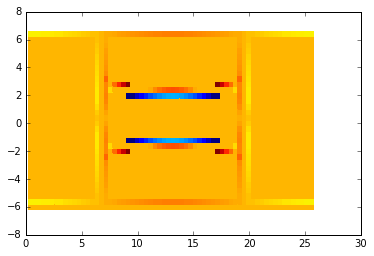

In [33]:
k = 0
pl.pcolor(xk[NO2:-NO2+1,NO2:-NO2+1,4],yk[NO2:-NO2+1,NO2:-NO2+1,4],
                            Ek[:,:,k])

In [34]:
    #Calculate current from the magnetic stresses, note dpB = JxB*dt
    JxB_x = dpxB/dt
    JxB_y = dpyB/dt
    JxB_z = dpzB/dt
    
    B = n.sqrt(bx_h**2+by_h**2+bz_h**2)
    bxn = bx_h/B**2
    byn = by_h/B**2
    bzn = bz_h/B**2
    
    Jxc = byn*JxB_z - bzn*JxB_y
    Jyc = bzn*JxB_x - bxn*JxB_z
    Jzc = bxn*JxB_y - byn*JxB_x
    

In [35]:
    #Calculate Hall electric fields from currents
    if (Hall): 
        vx_Hall = Jxc/rho_h
        vy_Hall = Jyc/rho_h
        vz_Hall = Jzc/rho_h
        #apply BC for v_Hall
        MHDpy.Boundaries(rho,p,vx_Hall,vy_Hall,vz_Hall,bi,bj,bk,NO,
                xtype=xbctype,ytype=ybctype,ztype=zbctype)
        # Hall drift velocity - not used in the Courant condition
        Vhdrif = n.sqrt(vx_Hall**2+vy_Hall**2+vz_Hall**2)
        
        # minimun dx for Whistler speed estimation
        d_min = dy.min()
        
        # calculate the Hall electric field, use the same code getEk, with
        # additional diffusion 
        (Ei_Hall,Ej_Hall,Ek_Hall) = MHDpy.getEk_Hall(vx_Hall,vy_Hall,vz_Hall,
            rho_h,p_h,gamma,bi_h,bj_h,bk_h,bx_h,by_h,bz_h,
            d_min,PDMB,limiter_type,CA)
        
        # the total electric field is then E + E_Hall
        Ei = Ei + Ei_Hall
        Ej = Ej + Ej_Hall
        Ek = Ek + Ek_Hall

In [36]:
    # update face-center magnetic fields (bi,bj,bk) through Faraday's law
    bi[NO2:-NO2,NO2:-NO2,NO2:-NO2] = bi[NO2:-NO2,NO2:-NO2,NO2:-NO2] - dt*( 
        1/dy[NO2:-NO2+1,NO2:-NO2,NO2:-NO2]*(Ek[:,1:,:]-Ek[:,:-1,:]) -
        1/dz[NO2:-NO2+1,NO2:-NO2,NO2:-NO2]*(Ej[:,:,1:]-Ej[:,:,:-1]) )
    bj[NO2:-NO2,NO2:-NO2,NO2:-NO2] = bj[NO2:-NO2,NO2:-NO2,NO2:-NO2] - dt*( 
        1/dz[NO2:-NO2,NO2:-NO2+1,NO2:-NO2]*(Ei[:,:,1:]-Ei[:,:,:-1])-
        1/dx[NO2:-NO2,NO2:-NO2+1,NO2:-NO2]*(Ek[1:,:,:]-Ek[:-1,:,:]) )
    bk[NO2:-NO2,NO2:-NO2,NO2:-NO2] = bk[NO2:-NO2,NO2:-NO2,NO2:-NO2] - dt*( 
        1/dx[NO2:-NO2,NO2:-NO2,NO2:-NO2+1]*(Ej[1:,:,:]-Ej[:-1,:,:])-
        1/dy[NO2:-NO2,NO2:-NO2,NO2:-NO2+1]*(Ei[:,1:,:]-Ei[:,:-1,:]) ) 
    
    # calculate bx, by, bz at cell center, 2nd order accurate,    
    bx = (bi[1:,:,:] + bi[:-1,:,:])/2.
    by = (bj[:,1:,:] + bj[:,:-1,:])/2.
    bz = (bk[:,:,1:] + bk[:,:,:-1])/2.                                              
    
    # get mid-time step total B field, using volume-averaged B at cell
    # this is B(n+1/2)
    bx1 = 0.5*(bx+bx0)
    by1 = 0.5*(by+by0)
    bz1 = 0.5*(bz+bz0)
    #this is B(n+1)
    bx2 = bx*1.
    by2 = by*1.
    bz2 = bz*1.  

In [54]:
    if (nsp > 1):
        # Gas Hydro for each species
        for i in n.arange(nsp):
            (rho2temp,vx2temp,vy2temp,vz2temp,eng2temp) = MHDpy.Gas_Hydro1(
                rhos_h[:,:,:,i],vxs_h[:,:,:,i],vys_h[:,:,:,i],vzs_h[:,:,:,i],
                ps_h[:,:,:,i],dx,dy,dz,NO2,PDMB,limiter_type,gamma,dt,CA)
            rhos2[:,:,:,i] = rho2temp
            vxs2[:,:,:,i] = vx2temp
            vys2[:,:,:,i] = vy2temp
            vzs2[:,:,:,i] = vz2temp
            engs2[:,:,:,i] = eng2temp
        rhos[NO2:-NO2,NO2:-NO2,NO2:-NO2,:] = (
            rhos0[NO2:-NO2,NO2:-NO2,NO2:-NO2,:]+
            rhos2[NO2:-NO2,NO2:-NO2,NO2:-NO2,:])
        rhovxs[NO2:-NO2,NO2:-NO2,NO2:-NO2,:] = (
            rhovxs0[NO2:-NO2,NO2:-NO2,NO2:-NO2,:]+
            vxs2[NO2:-NO2,NO2:-NO2,NO2:-NO2,:])
        rhovys[NO2:-NO2,NO2:-NO2,NO2:-NO2,:] = (
            rhovys0[NO2:-NO2,NO2:-NO2,NO2:-NO2,:]+
            vys2[NO2:-NO2,NO2:-NO2,NO2:-NO2,:])                    
        rhovzs[NO2:-NO2,NO2:-NO2,NO2:-NO2,:] = (
            rhovzs0[NO2:-NO2,NO2:-NO2,NO2:-NO2,:]+
            vzs2[NO2:-NO2,NO2:-NO2,NO2:-NO2,:])
        engs[NO2:-NO2,NO2:-NO2,NO2:-NO2,:] = (
            engs0[NO2:-NO2,NO2:-NO2,NO2:-NO2,:]+
            engs2[NO2:-NO2,NO2:-NO2,NO2:-NO2,:])
            
        vxs[NO2:-NO2,NO2:-NO2,NO2:-NO2,:] = (
            rhovxs[NO2:-NO2,NO2:-NO2,NO2:-NO2,:]/
            (n.spacing(1)+rhos[NO2:-NO2,NO2:-NO2,NO2:-NO2,:]))             
        vys[NO2:-NO2,NO2:-NO2,NO2:-NO2,:] = (
            rhovys[NO2:-NO2,NO2:-NO2,NO2:-NO2,:]/
            (n.spacing(1)+rhos[NO2:-NO2,NO2:-NO2,NO2:-NO2,:]))
        vzs[NO2:-NO2,NO2:-NO2,NO2:-NO2,:] = (
            rhovzs[NO2:-NO2,NO2:-NO2,NO2:-NO2,:]/
            (n.spacing(1)+rhos[NO2:-NO2,NO2:-NO2,NO2:-NO2,:]))
        ps[NO2:-NO2,NO2:-NO2,NO2:-NO2,:] = (
           engs[NO2:-NO2,NO2:-NO2,NO2:-NO2,:] - 
           0.5*rhos[NO2:-NO2,NO2:-NO2,NO2:-NO2,:]*(
           vxs[NO2:-NO2,NO2:-NO2,NO2:-NO2,:]**2+
           vys[NO2:-NO2,NO2:-NO2,NO2:-NO2,:]**2+
           vzs[NO2:-NO2,NO2:-NO2,NO2:-NO2,:]**2))*(gamma-1)
        #set pressure to zero where density is zero
        ps[rhos == 0] = 0
        #put the total mass and fluid stress changes in the bulk changes
        #sum over last dimension of stress/flux, these are used to calculate
        #velocities for each spcies and bulk
        drho = n.sum(rhos2,axis=3)
        dpxF = n.sum(vxs2,axis=3)
        dpyF = n.sum(vys2,axis=3)
        dpzF = n.sum(vzs2,axis=3)
        deng = n.sum(engs2,axis=3) 

In [52]:
print engs[:,:,:,0].min(),engs[:,:,:,0].max()

0.0600000000102 0.188345817912


In [ ]:
print vy2temp.min(),vy2temp.max()

In [57]:
    rho[NO2:-NO2,NO2:-NO2,NO2:-NO2] = (
            rho0[NO2:-NO2,NO2:-NO2,NO2:-NO2]+
            drho[NO2:-NO2,NO2:-NO2,NO2:-NO2])
    rhovx[NO2:-NO2,NO2:-NO2,NO2:-NO2] = (
            rhovx0[NO2:-NO2,NO2:-NO2,NO2:-NO2]+
            dpxF[NO2:-NO2,NO2:-NO2,NO2:-NO2])
    rhovy[NO2:-NO2,NO2:-NO2,NO2:-NO2] = (
            rhovy0[NO2:-NO2,NO2:-NO2,NO2:-NO2]+
            dpyF[NO2:-NO2,NO2:-NO2,NO2:-NO2])                    
    rhovz[NO2:-NO2,NO2:-NO2,NO2:-NO2] = (
            rhovz0[NO2:-NO2,NO2:-NO2,NO2:-NO2]+
            dpzF[NO2:-NO2,NO2:-NO2,NO2:-NO2])
    eng[NO2:-NO2,NO2:-NO2,NO2:-NO2] = (
            eng0[NO2:-NO2,NO2:-NO2,NO2:-NO2]+
            deng[NO2:-NO2,NO2:-NO2,NO2:-NO2])
                                                                                      
    # get plasma pressure - now rho and p are solved (to O(dt)?)
    vx = rhovx/rho
    vy = rhovy/rho
    vz = rhovz/rho
    p = (eng - 0.5*rho*(vx**2+vy**2+vz**2))*(gamma-1)

In [58]:
    # now apply the magnetic stress with Borris correction
    rho1 = rho
    b1 = n.sqrt(bx1**2+by1**2+bz1**2)
    b2 = n.sqrt(bx2**2+by2**2+bz2**2)
    alfn_ratio = b1**2/rho1/CA**2
    perp_ratio = 1.0/(1+alfn_ratio)
    bdx = dpxB/rho*perp_ratio
    bdy = dpyB/rho*perp_ratio
    bdz = dpzB/rho*perp_ratio
    # then update the bulk momentum with Alfven correction
    dv_alf = alfn_ratio*drho
    vx_tmp = alfn_ratio*(dpxF - drho*vx0)
    vy_tmp = alfn_ratio*(dpyF - drho*vy0)
    vz_tmp = alfn_ratio*(dpzF - drho*vz0)
    bdotv = bx1*vx_tmp+by1*vy_tmp+bz1*vz_tmp
    bdotv = bdotv/(b1**2+1e-10)
    rhovx = rhovx0 + perp_ratio *(dpxF + dpxB + dv_alf*vx0+bx1*bdotv)
    rhovy = rhovy0 + perp_ratio *(dpyF + dpyB + dv_alf*vy0+by1*bdotv)
    rhovz = rhovz0 + perp_ratio *(dpzF + dpzB + dv_alf*vz0+bz1*bdotv)
    
    # Get the new velocities with correction magnetic stress
    # now bulk vx,vy,vz are solved
    # NB - In the multifluid branch these velocities are used as perp 
    # velocities for every species since they are required to have same Vperp
    vx_new = rhovx/rho
    vy_new = rhovy/rho
    vz_new = rhovz/rho    

In [73]:
    if (nsp > 1):
        #Multi-species block
        # Calculate the perp bulk for each species
        vnewdotb = (bx2*vx_new+by2*vy_new+bz2*vz_new)/(b2**2+n.spacing(1))
        vxnew_perp = vx_new - bx2*vnewdotb
        vynew_perp = vy_new - by2*vnewdotb
        vznew_perp = vz_new - bz2*vnewdotb
        # Calculate the perp bulk fluid stress
        v2dotb = (bx1*dpxF + by1*dpyF + bz1*dpzF)/(b1**2+n.spacing(1));
        vx2_perp = dpxF - bx1*v2dotb
        vy2_perp = dpyF - by1*v2dotb
        vz2_perp = dpzF - bz1*v2dotb
        for ns in n.arange(nsp):
            #first estimate the Alfven constant for the perp momentum
            species_ratio[:,:,:,ns]=0.5*(rhos0[:,:,:,ns]/rho0[:,:,:] + 
                                            rhos[:,:,:,ns]/rho[:,:,:])
            drho_l[:,:,:,ns] = (rhos[:,:,:,ns]-rhos0[:,:,:,ns])
            alfn_star[:,:,:,ns] = alfn_ratio[:,:,:]*(1 - 
                0.5*drho_l[:,:,:,ns]/rhos[:,:,:,ns])
            perp_const_l[:,:,:,ns] = 1/(1+alfn_star[:,:,:,ns])
            drho_l[:,:,:,ns] = drho_l[:,:,:,ns]*alfn_star[:,:,:,ns]
            
            # apply the corrected momentum to each species without rotation
            vxtmp[:,:,:,ns] = ((1+alfn_star[:,:,:,ns])*vxs2[:,:,:,ns] - 
                                drho_l[:,:,:,ns]*vxs0[:,:,:,ns])
            vytmp[:,:,:,ns] = ((1+alfn_star[:,:,:,ns])*vys2[:,:,:,ns] - 
                                drho_l[:,:,:,ns]*vys0[:,:,:,ns])
            vztmp[:,:,:,ns] = ((1+alfn_star[:,:,:,ns])*vzs2[:,:,:,ns] - 
                                drho_l[:,:,:,ns]*vzs0[:,:,:,ns])
            vtmp_dotl[:,:,:,ns] = ((bx1[:,:,:]*vxtmp[:,:,:,ns] + 
                                    by1[:,:,:]*vytmp[:,:,:,ns] + 
                                    bz1[:,:,:]*vztmp[:,:,:,ns])/
                                    (b1[:,:,:]**2+n.spacing(1)))
            vx2_tmp[:,:,:,ns] = ((rhovxs0[:,:,:,ns] + 
                    perp_const_l[:,:,:,ns]*(drho_l[:,:,:,ns]*vxs0[:,:,:,ns] + 
                    species_ratio[:,:,:,ns]*vx2_perp + 
                    bx1[:,:,:]*vtmp_dotl[:,:,:,ns] ))/rhos[:,:,:,ns] +
                                bdx[:,:,:])
            vy2_tmp[:,:,:,ns] = ((rhovys0[:,:,:,ns] + 
                    perp_const_l[:,:,:,ns]*(drho_l[:,:,:,ns]*vys0[:,:,:,ns] + 
                    species_ratio[:,:,:,ns]*vy2_perp +
                    by1[:,:,:]*vtmp_dotl[:,:,:,ns] ))/rhos[:,:,:,ns] +
                                bdy[:,:,:])
            vz2_tmp[:,:,:,ns] = ((rhovzs0[:,:,:,ns] + 
                    perp_const_l[:,:,:,ns]*(drho_l[:,:,:,ns]*vzs0[:,:,:,ns] + 
                    species_ratio[:,:,:,ns]*vz2_perp + 
                    bz1[:,:,:]*vtmp_dotl[:,:,:,ns] ))/rhos[:,:,:,ns] + 
                                bdz[:,:,:])
                      
            # rotate to the b(n+1) direction to include the dB/dt term
            vtmp_dot_l2[:,:,:,ns] = ((bx2[:,:,:]*vx2_tmp[:,:,:,ns] + 
                                      by2[:,:,:]*vy2_tmp[:,:,:,ns] + 
                                      bz2[:,:,:]*vz2_tmp[:,:,:,ns])/
                                      (b2[:,:,:]**2+n.spacing(1)))          
            vx_para_l[:,:,:,ns] = vtmp_dot_l2[:,:,:,ns]*bx2[:,:,:]
            vy_para_l[:,:,:,ns] = vtmp_dot_l2[:,:,:,ns]*by2[:,:,:]
            vz_para_l[:,:,:,ns] = vtmp_dot_l2[:,:,:,ns]*bz2[:,:,:]
            
            # adding the common perp velocity to each species
            vxs[:,:,:,ns] = vxnew_perp[:,:,:]+vx_para_l[:,:,:,ns]
            vys[:,:,:,ns] = vynew_perp[:,:,:]+vy_para_l[:,:,:,ns]
            vzs[:,:,:,ns] = vznew_perp[:,:,:]+vz_para_l[:,:,:,ns]
        # apply BC for each species
        for ns in n.arange(nsp):
                MHDpy.Boundaries(rhos[:,:,:,ns],ps[:,:,:,ns],
                vxs[:,:,:,ns],vys[:,:,:,ns],vzs[:,:,:,ns],bi,bj,bk,NO,
                xtype=xbctype,ytype=ybctype,ztype=zbctype)
        vx = n.sum(vxs*rhos,axis=3)/rho
        vy = n.sum(vys*rhos,axis=3)/rho
        vz = n.sum(vzs*rhos,axis=3)/rho
        p = n.sum(ps,axis=3)
    else:
        #single fluid block
        vx = vx_new
        vy = vy_new
        vz = vz_new

In [66]:
print ps.min(),ps.max()

0.0400000000068 0.500774022476


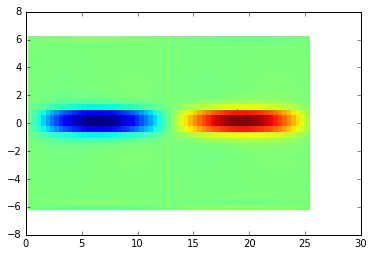

In [74]:
k = 4
pl.pcolor(xc[NO2:-NO2,NO2:-NO2,k],yc[NO2:-NO2,NO2:-NO2,k],
                            vx[NO2:-NO2,NO2:-NO2,k])

In [67]:
    # Apply Boundary Conditions to bulk
    MHDpy.Boundaries(rho,p,vx,vy,vz,bi,bj,bk,NO,
                    xtype=xbctype,ytype=ybctype,ztype=zbctype)  
                                        
    # calculate bx, by, bz at cell center, 2nd order accurate,    
    # bi,bj,bk are filled with ghost cells, so doing the whole grid here
    bx = (bi[1:,:,:] + bi[:-1,:,:])/2.
    by = (bj[:,1:,:] + bj[:,:-1,:])/2.
    bz = (bk[:,:,1:] + bk[:,:,:-1])/2.  

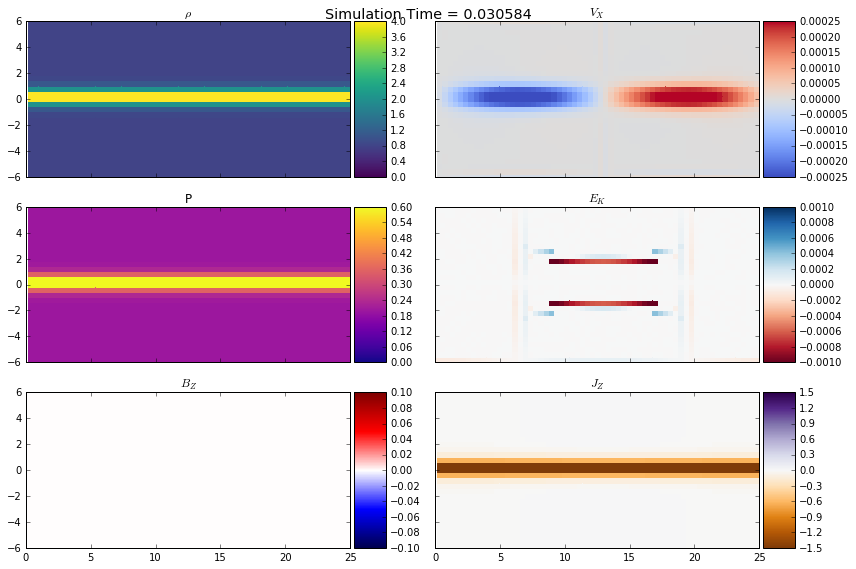

In [86]:
        k=4
        golden_mean = (n.sqrt(5)-1.0)/2.0
        figwidth = 12
        figheight = 8
        fig,ax=pl.subplots(nrows=3,ncols=2,figsize=(figwidth,figheight),sharex=True,sharey=True)
        
        levels = n.linspace(0,2,12)
        cf0 = ax[0,0].pcolor(xc[NO2:-NO2,NO2:-NO2,k],yc[NO2:-NO2,NO2:-NO2,k],
                            rho[NO2:-NO2,NO2:-NO2,k],vmin=0,vmax=4,cmap=pl.get_cmap('viridis'))
        divider0 = make_axes_locatable(ax[0,0])
        cax0 = divider0.append_axes("right", size="10%", pad=0.05)
        cbar0 = pl.colorbar(cf0,cax=cax0)
        ax[0,0].set_title(r'$\rho$')
        ax[0,0].set_xlim((0,25))
        ax[0,0].set_ylim((-6,6))
        
        levels = n.linspace(-1.0,1.0,13)
        cf1 = ax[0,1].pcolor(xc[NO2:-NO2,NO2:-NO2,k],yc[NO2:-NO2,NO2:-NO2,k],
                            vx[NO2:-NO2,NO2:-NO2,k],vmin=-2.5e-4,vmax=2.5e-4,cmap=pl.get_cmap('coolwarm'))
        divider1 = make_axes_locatable(ax[0,1])
        cax1 = divider1.append_axes("right", size="10%", pad=0.05)
        cbar1 = pl.colorbar(cf1,cax=cax1)
        ax[0,1].set_title(r'$V_X$')
        
        levels = n.linspace(0.0,2.0,13)
        cf2 = ax[1,0].pcolor(xc[NO2:-NO2,NO2:-NO2,k],yc[NO2:-NO2,NO2:-NO2,k],
                            p[NO2:-NO2,NO2:-NO2,k],vmin=0,vmax=0.6,cmap=pl.get_cmap('plasma'))
        divider2 = make_axes_locatable(ax[1,0])
        cax2 = divider2.append_axes("right", size="10%", pad=0.05)
        cbar2 = pl.colorbar(cf2,cax=cax2)
        ax[1,0].set_title('P')
        
        levels = n.linspace(-0.15,0.15,13)
        cf3 = ax[1,1].pcolor(x[NO2:-NO2,NO2:-NO2,k],y[NO2:-NO2,NO2:-NO2,k],
                            Ek[:,:,0],vmin=-1.0e-3,vmax=1.0e-3,cmap=pl.get_cmap('RdBu'))
        divider3 = make_axes_locatable(ax[1,1])
        cax3 = divider3.append_axes("right", size="10%", pad=0.05)
        cbar3 = pl.colorbar(cf3,cax=cax3)
        ax[1,1].set_title(r'$E_K$')
        
        
        levels = n.linspace(-1.0,1.0,13)
        cf4 = ax[2,0].pcolor(xc[NO2:-NO2,NO2:-NO2,k],yc[NO2:-NO2,NO2:-NO2,k],
                            bz[NO2:-NO2,NO2:-NO2,k],vmin=-0.1,vmax=0.1,cmap=pl.get_cmap('seismic'))
        divider4 = make_axes_locatable(ax[2,0])
        cax4 = divider4.append_axes("right", size="10%", pad=0.05)
        cbar4 = pl.colorbar(cf4,cax=cax4)
        ax[2,0].set_title(r'$B_Z$')
        
        levels = n.linspace(-1.0e-13,1.0e-13,13)
        cf5 = ax[2,1].pcolor(xc[NO2:-NO2,NO2:-NO2,k],yc[NO2:-NO2,NO2:-NO2,k],
                            Jzc[NO2:-NO2,NO2:-NO2,k],vmin=-1.5,vmax=1.5,cmap=pl.get_cmap('PuOr'))
        divider5 = make_axes_locatable(ax[2,1])
        cax5 = divider5.append_axes("right", size="10%", pad=0.05)
        cbar5 = pl.colorbar(cf5,cax=cax5)
        ax[2,1].set_title(r'$J_Z$')
                
       
        fig.suptitle('Simulation Time = %f' % Time,fontsize='x-large')
        pl.tight_layout()
        saveFigName = os.path.join(imagedir,'%s-%06d.png'%(imagebase,imageNum))

In [ ]:
cm = pl.colormaps